In [32]:
#general modules
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction import text
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
from sklearn.feature_extraction.text import TfidfVectorizer

#modules for n-gram model
#warnings ot surpressed
import tensorflow as tf
from tensorflow import keras
from keras import models
from keras.layers import Dense
from keras.layers import Dropout
from keras.optimizers import Adam
from keras import backend as K #backend to use outside metrics on n-gram model


In [5]:
train = pd.read_csv('Train.csv')

In [6]:
#Number of samples
sample_tot = len(train.index.values)
print(sample_tot)

15819


In [7]:
#Number of classes
sent_val = set(train['sentiment'].values)
sent_count = len(set(train['sentiment'].values))
print(sent_val)
print(sent_count)

{0, 1, 2, -1}
4


In [8]:
#number of samples per class
for i in set(train['sentiment'].values):
    count = 0
    for x in train['sentiment']:
        if x == i:
            count+=1
    print("Sentiment "+ str(i)+' '+ "observations :"+ str(count))

Sentiment 0 observations :2353
Sentiment 1 observations :8530
Sentiment 2 observations :3640
Sentiment -1 observations :1296


In [9]:
#median words per tweet
def word_count(text):
    num_words = [len(s.split()) for s in text]
    return np.median(num_words)
words = word_count(train['message'])
print(words)

18.0


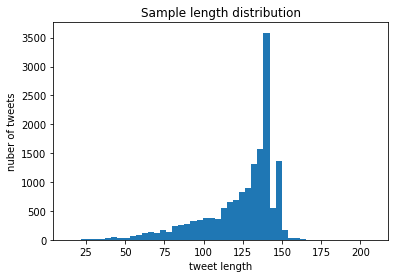

In [10]:
#distr. tweet lengths
def sample_plotter(text2):
    plt.hist([len(s) for s in text2], 50)
    plt.xlabel('tweet length')
    plt.ylabel('nuber of tweets')
    plt.title('Sample length distribution')
    plt.show()

sample_plotter(train['message'])

In [11]:
train.head()

,sentiment,message,tweetid
0,1,PolySciMajor EPA chief doesn't think carbon di...,625221
1,1,It's not like we lack evidence of anthropogeni...,126103
2,2,RT @RawStory: Researchers say we have three ye...,698562
3,1,#TodayinMaker# WIRED : 2016 was a pivotal year...,573736
4,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, ...",466954


In [12]:
#word sample ratios
word_sample_ratio = sample_tot/words
print(round(word_sample_ratio, 0))

879.0


In [13]:
#sentiment prep
def adder(text):
    num = int(text)
    num = num + 1
    return num
train['sentiment'] = train['sentiment'].apply(adder)
train['sentiment'] = train['sentiment'].replace(3, 2) #combining thwe last two classes to work with the n-gram 
train['sentiment']

0        2
1        2
2        2
3        2
4        2
        ..
15814    2
15815    2
15816    1
15817    0
15818    1
Name: sentiment, Length: 15819, dtype: int64

In [17]:
#stop words
stop2 = text.ENGLISH_STOP_WORDS
stop = set(stopwords.words('english'))

In [18]:
X = train.iloc[:, 1].values
y = train.iloc[:, 0].values

In [19]:
#test and train
from sklearn.model_selection import train_test_split
train_text, test_text, train_val, test_val = train_test_split(X, y, test_size=0.20, shuffle = True, random_state=32)

In [26]:
#tokenizing into uni+bi-grams and vectorizing
from sklearn.feature_extraction.text import TfidfTransformer


t_vector = TfidfVectorizer(ngram_range=(1, 2),
                            
                           strip_accents = 'unicode',
                           decode_error = 'replace',
                           analyzer = 'word',
                           min_df = .1, 
                           max_df = .50,
                           stop_words = stop)
x_train = t_vector.fit_transform(train_text)
x_val = t_vector.transform(test_text)

In [27]:
#Selecting top 20 000 Features for n-gram model
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

b_vect = SelectKBest(f_classif, k = min(20000, x_train.shape[1]))
b_vect.fit(x_train, train_val)
x_train = b_vect.transform(x_train).astype('float32')
x_val = b_vect.transform(x_val).astype('float32')


In [28]:
x_train

<12655x5 sparse matrix of type '<class 'numpy.float32'>'
	with 11938 stored elements in Compressed Sparse Row format>

In [29]:
x_val

<3164x5 sparse matrix of type '<class 'numpy.float32'>'
	with 3131 stored elements in Compressed Sparse Row format>

In [30]:
#building  multilayer perceptron
#not optimized

drop_rate = 0.2
layers = 2
clasif = models.Sequential()
clasif.add(Dropout(rate = drop_rate, input_shape = x_train.shape[1:]))
for lvl in range(layers - 1):
    clasif.add(Dense(units = 3, activation = 'relu'))
    clasif.add(Dropout(rate = 0.1))
clasif.add(Dense(units = 3,activation = 'softmax'))

In [33]:
#N-gram model training and validation. Haven't used balance library
#Metrics calc for metrics not available in Keras. Funcs from Stackoverflow

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


optimizer = Adam(lr = 1e-3)
clasif.compile(optimizer, loss = 'sparse_categorical_crossentropy', metrics = ['acc', f1_m, precision_m, recall_m]) # can remove the above metrics from here for a cleaner readout
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)]
history = clasif.fit(
            x_train,
            train_val,
            epochs=1000,
            batch_size = 128,
            callbacks=callbacks,
            validation_data=(x_val, test_val),
            verbose=2,  # Logs once per epoch.
            )
history = history.history
print('Validation accuracy: {acc}, loss: {loss}, f1_score: {f1}'.format(acc=history['val_acc'][-1], loss=history['val_loss'][-1], f1 = history['val_f1_m']))


Train on 12655 samples, validate on 3164 samples
Epoch 1/1000
 - 0s - loss: 1.0303 - acc: 0.7512 - f1_m: 4.4412 - precision_m: 893131328.0000 - recall_m: 2.3923 - val_loss: 0.9719 - val_acc: 0.7724 - val_f1_m: 3.6293 - val_precision_m: 10.0274 - val_recall_m: 2.2285
Epoch 2/1000
 - 0s - loss: 0.9261 - acc: 0.7682 - f1_m: 3.4401 - precision_m: 8.1041 - recall_m: 2.2074 - val_loss: 0.8837 - val_acc: 0.7724 - val_f1_m: 2.5653 - val_precision_m: 4.7825 - val_recall_m: 1.7585
Epoch 3/1000
 - 0s - loss: 0.8516 - acc: 0.7685 - f1_m: 2.1356 - precision_m: 3.2231 - recall_m: 1.7311 - val_loss: 0.8196 - val_acc: 0.7724 - val_f1_m: 1.7136 - val_precision_m: 1.7502 - val_recall_m: 1.6798
Epoch 4/1000
 - 0s - loss: 0.7944 - acc: 0.7685 - f1_m: 1.2644 - precision_m: 1.2728 - recall_m: 1.2584 - val_loss: 0.7629 - val_acc: 0.7724 - val_f1_m: 1.0672 - val_precision_m: 1.0247 - val_recall_m: 1.1139
Epoch 5/1000
 - 0s - loss: 0.7441 - acc: 0.7685 - f1_m: 0.9938 - precision_m: 0.9599 - recall_m: 1.0306 -

In [35]:
clasif.predict_classes(x_val) #predicting classes with the n-gram

array([2, 2, 2, ..., 2, 2, 2], dtype=int64)

In [1]:
'''
from imblearn.over_sampling import KMeansSMOTE, ADASYN, SMOTE, BorderlineSMOTE, SVMSMOTE, SMOTENC, RandomOverSampler
from imblearn.pipeline import make_pipeline
pipeline = make_pipeline(RandomOverSampler(random_state=32), CatBoostClassifier(depth=9, 
                                                                                bootstrap_type= 'Bayesian', 
                                                                                loss_function = 'MultiClass', 
                                                                                iterations=80, learning_rate=0.4, l2_leaf_reg=26))
pipeline.fit(X_trainer, y_trainer)
'''

"\nfrom imblearn.over_sampling import KMeansSMOTE, ADASYN, SMOTE, BorderlineSMOTE, SVMSMOTE, SMOTENC, RandomOverSampler\nfrom imblearn.pipeline import make_pipeline\npipeline = make_pipeline(RandomOverSampler(random_state=32), CatBoostClassifier(depth=9, \n                                                                                bootstrap_type= 'Bayesian', \n                                                                                loss_function = 'MultiClass', \n                                                                                iterations=80, learning_rate=0.4, l2_leaf_reg=26))\npipeline.fit(X_trainer, y_trainer)\n"